In [1]:
#Kspice
import sys
sys.path.append(r"C:\Program Files (x86)\Kongsberg\K-Spice\bin64") #add to path to allow kspice import
import kspice # if import error, check correct python version (should be 3.11)

#Basic functionality
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#ML
import torch 

from enviroment import Sim
from DQN import DQN

In [2]:
project_path = r"C:\Appl\K-Spice-Projects\Kristin_v23" #Specify path to downloaded project.
_ = kspice.Simulator(project_path) #Create instance of project

In [3]:
#This cell should contain the disabling of the power and wells modules - functionality not found in python API

# Only disable the modules, do not activate the timeline from the software as this is done in the next cell

In [4]:
timeline = _.activate_timeline("Engineering") # Select the avaliable engineering timeline
app = "Topside" # We only make changes to the topside module NOTE: From software we can #deactivate Wells and Power in ESS model, can this be done from python?
timeline.initialize() #

In [5]:
timeline.load_model("KristinMaria_master_disabledPowerWells") #Load model
timeline.load_parameters("KristinMaria_master_disabledPowerWells") # load fixed parameters
timeline.load_initial_condition("KristinMaria_master_disabledPowerWells") # Load initial conditions

In [ ]:
env = Sim(timeline, app)
env.import_variables("two_controllers.xlsx")

In [40]:
env.check_df("Input")

In [41]:
env.timeline.run()

RuntimeError: Run failed

In [42]:
def select_action(state):
    """ To ensure the model explores new spaces we will sometimes choose actions randomly. If not random we choose the action which result in the highest expected reward. 
    Choosing a random action will decay exponientially throughout learning. 
    """
    EPS_START = 0.9
    EPS_END = 0.05
    EPS_DECAY = 1000

    global steps_done
    sample = np.random.rand(1)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            pol_out = policy_net(state).max(1).indices
            return torch.tensor(env.action_pairs[pol_out.item()])
    else:
        return torch.tensor(env.sample("action"), dtype=torch.float32) # random action, unsqueeze such that one action has shape (1,1) i.e. env.step works since we index action[0]

In [43]:
state = env.reset()
print(state)

(array([12.99645603, 44.98098195]), array([0.00418826]), array([13., 45.]))


In [44]:
n_states = sum([len(state[i]) for i in range(len(state))]) # the flattened state output will be the input layer to the network
n_actions = 9 # (up, down, stay) x (up, down, stay)

In [45]:
policy_net = DQN(n_states, n_actions)
target_net = DQN(n_states, n_actions) # To increase stability we have an additional target network which "soft updates" the weigths to the policy net.
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [46]:
import itertools
state_flat = np.array(list(itertools.chain.from_iterable(state)))
state_tensor = torch.tensor(state_flat, dtype=torch.float32).unsqueeze(0) # make torch tensor and add axis

In [47]:
steps_done = 0
action = select_action(state_tensor) #Simulator input must be floats but DQN input should be tensor 
print(action, env.action_pairs.index(tuple(float(i) for i in action)))

tensor([1., 0.]) 3


In [48]:
observation, reward, terminated, truncated = env.step(action, step_change=0.15)
reward = torch.tensor([reward])
done = terminated or truncated
print(reward, done)

S23FIT1014 has reached its setpoint 12.901296217880896 [m3/h], prog.list: [1] 

S23LT1006 has reached its setpoint 45.05154880515641 [%], prog.list: [] 

tensor([1]) False


In [49]:
import random 
from collections import namedtuple, deque


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
#Class to store action state pairs

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

memory = ReplayMemory(100)

In [50]:
ns = np.array(list(itertools.chain.from_iterable(observation)))
next_state = torch.tensor(ns, dtype=torch.float32).unsqueeze(0) # make torch tensor and add axis

action_idx = env.action_pairs.index(tuple(float(i) for i in action))

# Store the transition in memory
memory.push(state_tensor, torch.tensor(action_idx, dtype=torch.int64).view(1,1), next_state, reward)

# Move to the next state
state = next_state

In [51]:
memory.sample(len(memory)) #visualize memory

[Transition(state=tensor([[1.2996e+01, 4.4981e+01, 4.1883e-03, 1.3000e+01, 4.5000e+01]]), action=tensor([[3]]), next_state=tensor([[1.2846e+01, 4.5052e+01, 4.1793e-03, 1.2850e+01, 4.5150e+01]]), reward=tensor([1]))]

In [52]:
import torch.nn as nn


LR = 1e-4 #Learing rate of optimizer
optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])


    #NOTE state is tuple so we need to reshape to be able to concat
    state_batch = torch.cat(batch.state) 
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch) #gather policy output with action indices along axis 1 

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100) # we dont want too big gradients
    optimizer.step()

    return loss

In [53]:
BATCH_SIZE = 2 # number of transitions sampled from the replay buffer
GAMMA = 0.99 # The factor in the discounted cumulative reward, we care about the rewards in the future but with a discount factor gamma. 
TAU = 0.005 # The target network should change slowly to improve stability - hence a soft update, with the TAU factor, of the target weights is used.  


# Perform one step of the optimization (on the policy network)
optimize_model()

In [57]:
# set up matplotlib
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


rewards = []
consumptions = []
flows = []
levels = []
losses = []


def plot_results():
    fig, axs = plt.subplots(5, sharex=True, figsize = (19, 8))

    axs[0].plot(consumptions, 'o-', color = 'C0', linewidth = 0.5, label = "Power Consumption")
    axs[0].legend(loc="upper right")


    axs[1].plot(rewards, marker = 'o', color = 'C1', linewidth = 0, label = "Reward")
    axs[1].legend(loc="upper right")

    axs[2].plot(flows, 'o-', color = 'C2', linewidth = 0.5, label = "Flow")
    axs[2].legend(loc="upper right")

    axs[3].plot(levels, 'o-', color = 'C3', linewidth = 0.5, label = "Level")
    axs[3].legend(loc="upper right")

    axs[4].plot(losses, 'o-', color = 'C4', linewidth = 0.5, label = "Loss")
    axs[4].legend(loc="upper right")


    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(1)

In [55]:
env.timeline.set_speed(100)

100.0

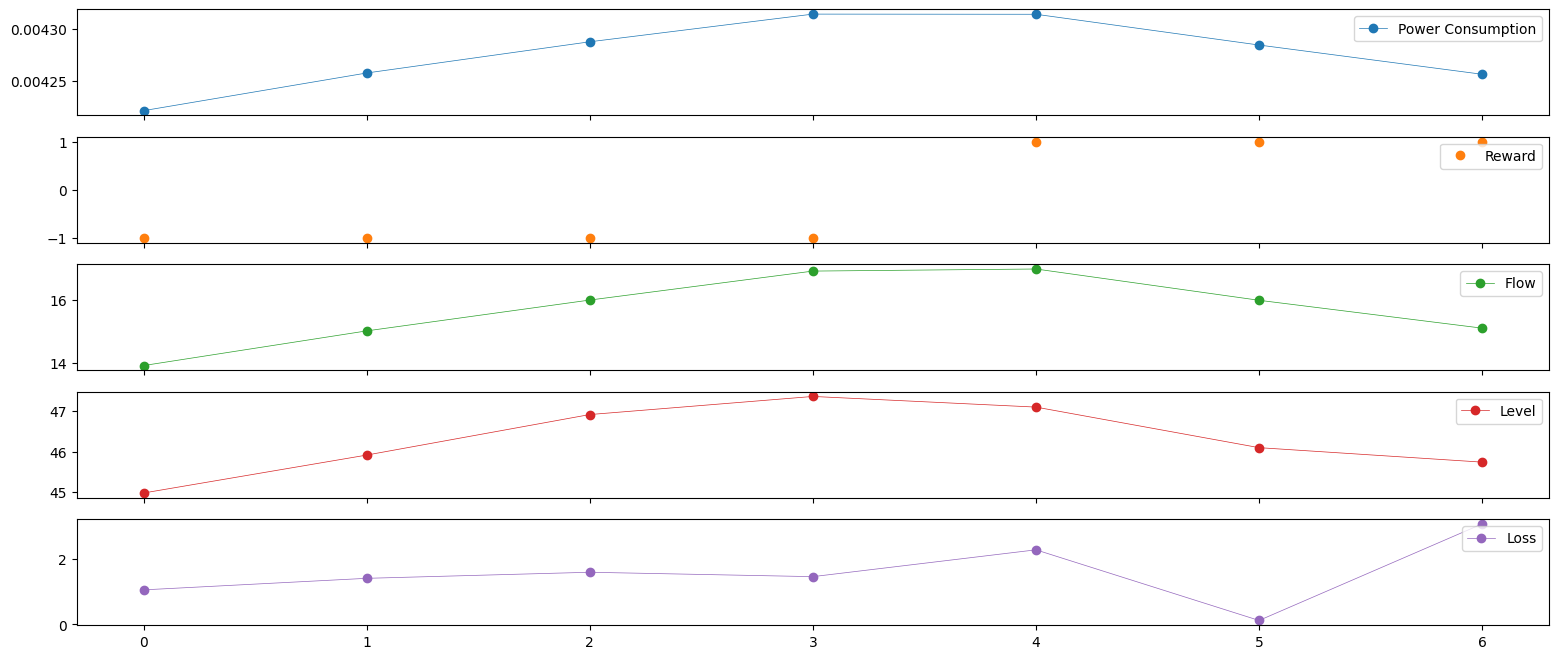

In [ ]:
from itertools import count # we just want an iterable and break the episode by truncated or terminated

for i_episode in range(1):
    # Initialize the environment and get its state
    state = env.reset()
    state_flat = np.array(list(itertools.chain.from_iterable(state)))
    state_tensor = torch.tensor(state_flat, dtype=torch.float32).unsqueeze(0) # make torch tensor and add axis
    for t in count():
        action = select_action(state_tensor)
        observation, reward, terminated, truncated = env.step(action, step_change=1)
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            obs_flat = np.array(list(itertools.chain.from_iterable(observation)))
            next_state = torch.tensor(obs_flat, dtype=torch.float32).unsqueeze(0)



        action_idx = env.action_pairs.index(tuple(float(i) for i in action))

        # Store the transition in memory
        memory.push(state_tensor, torch.tensor(action_idx, dtype=torch.int64).view(1,1), next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)


        rewards.append(reward[0])

        #NOTE this indexing is scary, changes when adding more ctrlers 
        consumptions.append(state[0][2])
        flows.append(state[0][0])
        levels.append(state[0][1])
        losses.append(loss.detach())

        plot_results()


        if done: 
            break 